# 1d spectral extraction using simple summation and optimum spectral extraction

***

**Author:** Tri L. Astraatmadja, tastraatmadja@stsci.edu
<br>
**Date:** September 3 2025

This note demonstrates a simple method to recover a calibrated 1d spectrum of a point source, by using simple summation along the cross-dispersion axis. We'll use `sncosmo` to generate the spectrum of a Type Ia Supernova (without the host-galaxy. Let's keep things simple for now) and put it in the center of a datacube, which we'll pass to the <i>Ilia</i> simulator to generate <i>Roman</i> 2d spectral image. We'll then try to recover the original input 1d spectrum from the observed 2d spectrum.
<br>
Afterwards, we'll also demonstrate a technique called optimum spectral extraction <a href="https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract">(Horne 1986)</a> to do the same task and see what are the advantages of this technique compared to a simple summation.
<br>
Before we begin, in order for this notebook to run properly, it is recommended to install the simulator `Ilia`. Follow the instructions on <a href="https://gitlab.com/astraatmadja/Ilia/-/blob/master/notebook/01%20-%20Ilia%20installation%20and%20demonstration.ipynb?ref_type=heads">this notebook</a>, download the relevant data files, and make sure everything runs.

In [1]:
from astropy import modeling
from astropy import units as u
from ilia import constants
from ilia.environment.scene import PointSourceScene
from ilia.instrument.disperser import RomanPrism
from ilia.instrument.throughput import RomanEffectiveArea
from ilia.simulator import RomanDisperserSimulator
from ilia.tools import plotting
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd
from scipy import constants as sciconstants
from scipy import integrate, interpolate
import sncosmo
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler
import synphot as syn

## Golden ratio
GOLDEN_RATIO = sciconstants.golden_ratio

LAMBDA_GRID = constants.LAMBDA_GRID

/opt/miniconda3/envs/hst/lib/python3.13/site-packages/stsci/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


INFO MainProcess> Logger (slitlessutils) with level=10 at 2025-09-04 10:57:30.989111


## Generating Supernova Ia spectrum using `sncosmo`

Let's use `sncosmo` to generate a supernova spectrum using the <a href="https://ui.adsabs.harvard.edu/abs/2007ApJ...663.1187H/abstract">Hsiao 2007</a> template. We'll use a relatively "nearby" supernova at redshift $z=0.5$ and time $t_0$ at maximum brightness of the supernova.

In [2]:
## Generate the supernova spectrum using sncosmo
# redshift
redshift = 0.5

## SN time from maximum
t0 = 0.0 ## This means maximum brightness

## Initialize the model
model = sncosmo.Model(source='hsiao')

## Set the redshift and time since maximum
model.set(z=redshift, t0=t0)

## Normalize the SN such that it's absolute magnitude in the Bessell V-band is M_V = -19.5
model.set_source_peakabsmag(-19.5, 'bessellv', 'ab')

## Print the model parameters and magnitude to get a sense of how bright it is
for name in model.param_names:
    print(name, model[name])
print(model.bandmag('sdssz', 'ab', t0), model.bandflux('sdssz', t0))

## Here the output flux unit from sncosmo is FLAM (synphot lingo for ergs/s/cm2/A. FLAM = F lambda), so we'll attach that unit using synphot
sn_flux_flam = model.flux(t0, LAMBDA_GRID.to_value(u.angstrom)) * syn.units.FLAM

## We'll need the flux in PHOTLAM (photons/s/cm2/A) later for comparison with the recovered 1d spectrum, so we'll do unit conversion here,
## again using synphot
sn_flux_photlam = syn.units.convert_flux(LAMBDA_GRID, sn_flux_flam, syn.units.PHOTLAM)

z 0.5
t0 0.0
amplitude 7.836417804991638e-10
22.37681520385283 6.539716124861575e-05


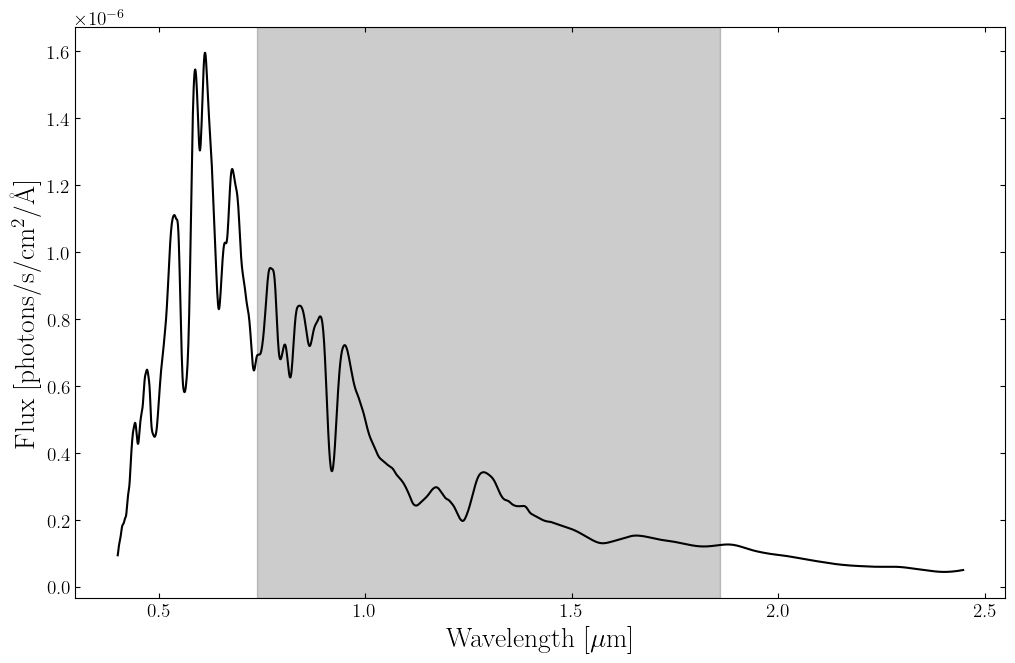

In [3]:
## Plot the spectrum, see if everything's alright
xSize = 12
ySize = xSize / GOLDEN_RATIO

opacity = 0.2

plotting.def_plot_values_extra_large()

fig = plt.figure(figsize=(xSize, ySize))

ax  = fig.add_subplot(111)

ax.plot(LAMBDA_GRID.to(u.micron), sn_flux_photlam, 'k-')

yMin, yMax = ax.get_ylim()

## Draw the relevant spectral range of Roman prism
ax.fill_betweenx(np.array([yMin, yMax]), 0.738, x2=1.859, color='black', alpha=opacity)

ax.set_ylim(yMin, yMax)

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'Flux [photons/s/cm$^2$/\AA]');

Looks fine! Let's move on...

## Constructing the scene and simulating the 2d spectrum

We'll assume that host-galaxy of the supernova has been perfectly removed (I know it might be asking a lot to suspend the reader's disbelief on this matter, but hopefully for the purpose of this demonstration readers can do this). Since the supernova can be safely assumed to be a point source, we'll use the PointSourceScene class from `Ilia`, which only store the fluxes of the spectrum in a single point in a sparse matrix. This makes everything faster when we run the simulator.

In [4]:
## Constructing the datacube. We'll take it to be 51 x 51 Roman pixel and oversampled by a factor of 5
nPP, nQQ = 51, 51

oversample = 5

## We assume that the host-galaxy has been perfectly removed and what remains is the supernova, which can safely be assumed 
## to be a point source. Hopefully you can suspend your disbelief that we can perfectly remove the host-galaxy 
scene = PointSourceScene(nPP, nQQ, oversample, LAMBDA_GRID, sn_flux_flam)

nL, nP, nQ = scene.nL, scene.nP, scene.nQ

Now we have the scene and ready to run the simulator and generate a 2d spectrum. Let's define some observational parameters: The exposure time, the dithering, and the roll angle of the observations. Don't worry about the dither and roll angle, just set the exposure time to 30 minutes.

In [5]:
## Some parameters of the simulator
exposureTimeSp = 3600.0 * u.s ## Exposure time for spectroscopic observations

## Dither pattern: shift_x, shift_y, and angle
ditherPattern = [(0.033 * u.arcsec, 0.0 * u.arcsec, 0.0 * u.deg)]

In [6]:
## Fire up the simulator and generate the spectrum using the parameters above
simulator = RomanDisperserSimulator(disperser='prism', oversample=oversample)
hduList   = simulator.simulatePointSourceSpectra(scene, dithers=ditherPattern, exposureTime=exposureTimeSp)

hduList.info()

DITHER PATTERN 1/1: (0.033 arcsec, 0.000 arcsec, 0.000 deg), FRACTIONAL PIXEL SHIFT: 0.000 pix
NEW_PSF_SHAPE: (509, 509, 1040)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


DONE! ELAPSED TIME: 0 h 0 m 7.189 s
ALL DONE! ELAPSED TIME: 0 h 0 m 7.231 s
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        32   (51, 259)   float64   
  2  ERR           1 ImageHDU        32   (51, 259)   float64   
  3  TRUE          1 ImageHDU        32   (51, 259)   float64   
  4  WAVEPIX       1 BinTableHDU     18   208R x 1C   ['D']   


The simulator will generate an `astropy` HDUList object containing the observed image, error image (standard deviation of each measured pixel), as well as the noise-free image. In addition to these images, the wavelength will also be given, as well as the background image used to generate the sky noise.

Let's plot the 2d spectra images, both the noise-free and noisy data. Note that <i>Roman</i> prism disperse light along the $y$ axis in detector space. For illustration purpose, we'll transpose the image that it'll disperse horizontally.

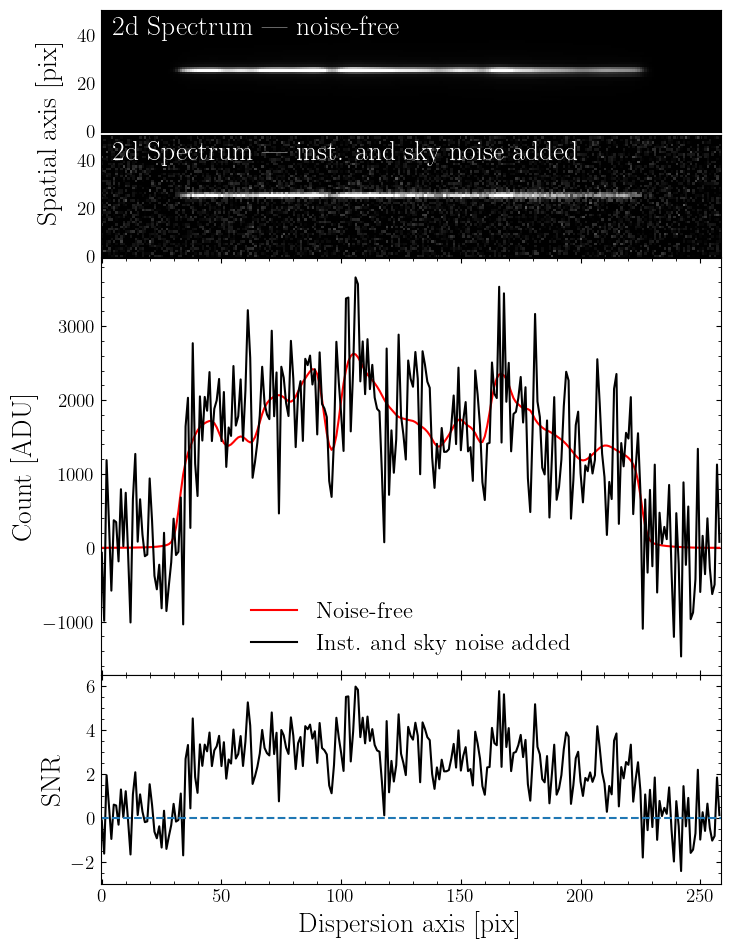

In [7]:
## Plot the 2d spectra images, the noise-free and the noisy data
nRows = 4
nCols = 1

xSize = 8
ySize = 2.3 * xSize/GOLDEN_RATIO

wspace = 0.00
hspace = 0.00

dX, dMX = 50, 10
dY, dMY = 20, 5

CI   = 99.0
P_HI = 0.5*(100.0 + CI)

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=False, height_ratios=[0.3, 0.3, 1, 0.5], figsize=(xSize, ySize))

for k in range(2):
    ax = axes[k]

    ## Grab the noise-free image from the HDUList. Also sum the fluxes along the cross-dispersion axis to get a hang of what 
    ## the 1d spectrum would look like
    if (k == 0):
        title = '2d Spectrum --- noise-free'
        image = hduList['TRUE', 1].data.T
        
        spec1d_noiseFree = image.sum(0)

    ## Now we grab and display the noisy image.
    if (k == 1):
        title = '2d Spectrum --- inst. and sky noise added'
        image = hduList['SCI', 1].data.T
        
        stdDevImage = hduList['ERR', 1].data.T

        spec1d_noisy = image.sum(0)
        stdDev1d     = np.sqrt((stdDevImage ** 2).sum(0))

        ## Signal to noise ratio: Measured count over the measured uncertainties (std. dev.)
        snr1d = spec1d_noisy / stdDev1d
        
        ax.set_xlabel(r'Dispersion axis [pix]')
        
    vmin, vmax = 0.0, np.percentile(image, P_HI)

    ax.imshow(image, aspect='equal', cmap='gray', origin='lower', vmin=vmin, vmax=vmax, interpolation='nearest')
        
    ax.text(0.02, 0.95, title, color='white', ha='left', va='top', transform=ax.transAxes)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(dX))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(dMX))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(dY))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

    ## ax.set_ylabel(r'Spatial axis [pix]');

dY, dMY = 1000, 200

axes[2].plot(spec1d_noiseFree, color='r', label='Noise-free')
axes[2].plot(spec1d_noisy, color='k', label='Inst. and sky noise added')

axes[2].legend(frameon=False, loc='best')

axes[2].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[2].set_ylabel(r'Count [ADU]')

axes[3].plot(snr1d, color='k')

axes[3].axhline(linestyle='--')

axes[3].set_xlabel(r'Dispersion axis [pix]')

dY, dMY = 2, 0.5

axes[3].set_ylim(-3, 6.5)
axes[3].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[3].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[3].set_ylabel(r'SNR')

plt.subplots_adjust(wspace=wspace, hspace=hspace)

## Make common label for the first two plots
axes[0].text(-0.06, 0.0, r'Spatial axis [pix]', rotation='vertical', ha='right', va='center', transform=axes[0].transAxes);

There's quite a lot of noise when we sum everything along the dispersion axis! This is the point of a simple summation, is to find a good balance between aperture width and signal-to-noise.

## 1d Spectral extraction by simple summation along the cross-dispersion axis

Below we're now going to extract 1d spectrum from the noisy image using several aperture width: $w = 1$ (just the central row), $w = 3$ (one row above and below the central row), and $w=11$ (five rows above and below the central row).

In [8]:
## Declare the half-width, which are 0, 1, and 5
dKs    = np.array([0, 1, 5], dtype=int)
colors = ['#7bccc4','#43a2ca','#0868ac']

25 233


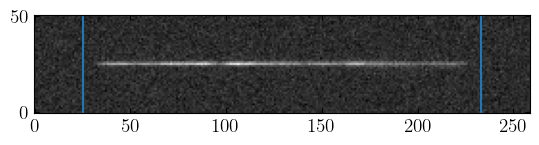

In [9]:
## Grab the noisy image from the HDUList, and transpose so that the dispersion axis is along the horizontal axis
noisySpec   = hduList['SCI'].data.T
stdDevImage = hduList['ERR'].data.T

## Get shape of the image
nK, nM = noisySpec.shape

## Find the zero-point of the extraction. The vertical zero-point is the central row, containing the object 
## which spectrum we want to extract. The horizontal zero-point is location of the reference wavelength, which
## is written in the header and (hopefully) is based on some calibration efforts
y_c, x_c = (nK // 2), int(hduList['WAVEPIX', 1].header['W_REFPIX'])

## This is the range of extraction along the dispersion axis, which is as long as the 
## wavelength array
xxMin, xxMax = x_c, x_c + hduList['WAVEPIX', 1].data['wavelength'].size

print(xxMin, xxMax)

## quick plot of the data
plt.imshow(noisySpec, cmap='grey', origin='lower')

plt.axvline(xxMin)
plt.axvline(xxMax)

In [10]:
## We'll declare an empty array to contain the extracted 1d spectra
spec1d_uncalib         = np.zeros((len(dKs), hduList['WAVEPIX', 1].data['wavelength'].size))
spec1d_uncalib_stdDev  = np.zeros_like(spec1d_uncalib)

## We'll now cycle over the half-widths and extract 1d spectra based on a given half-width
for k, dK in enumerate(dKs):
    ## Define the cross
    yyMin = max(0,  y_c - dK)
    yyMax = min(nK, y_c + dK+1)

    print(dK, y_c, yyMin, yyMax)

    ## This is the main event, where we grab the relevant area in the data and sum it along the cross-dispersion axis.
    ## Note that previously we transpose the data so that the cross-dispersion axis is along the vertical.
    ## We'll save this arrays of 1d spectra because we'll use them later
    spec1d_uncalib[k]        = noisySpec[yyMin:yyMax, xxMin:xxMax].sum(0)
    spec1d_uncalib_stdDev[k] = np.sqrt((stdDevImage[yyMin:yyMax, xxMin:xxMax] ** 2).sum(0))

0 25 25 26
1 25 24 27
5 25 20 31


0 25 25 26
1 25 24 27
5 25 20 31


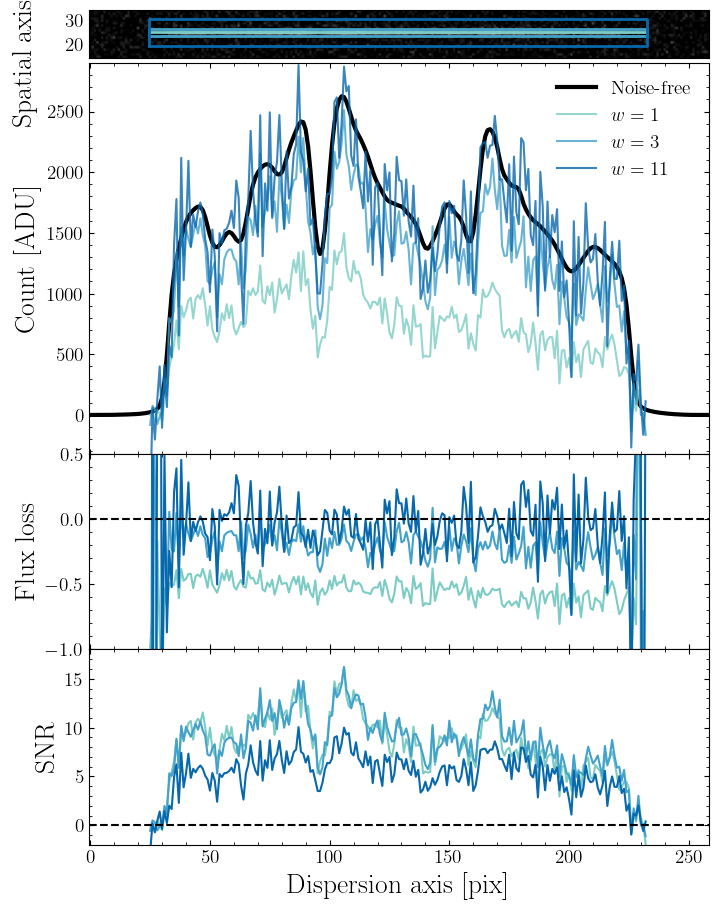

In [11]:
## Some plotting declarations
nRows = 4
nCols = 1

xSize = 8
ySize = 2.0 * xSize / GOLDEN_RATIO

CI  = 99.5
pHi = 0.5 * (100.0 + CI)

dCut = 10

opacity = 0.8

plotting.def_plot_values_extra_large()
                
fig, axes = plt.subplots(figsize=(xSize, ySize), ncols=nCols, nrows=nRows, sharex=True, sharey=False, height_ratios=[0.15, 1.0, 0.5, 0.5])

plt.subplots_adjust(hspace=0.0, top=0.95, bottom=0.1)

dX, dMX = 50, 10
dY, dMY = 10, 2

## This is the pixel coordinate along the dispersion axis, but we only use the parts
## where there are non-zero fluxes from the source, and here it is based on the wavelength array
pixCoords = np.arange(nM, dtype=int)[xxMin:xxMax]
    
vmin = 0.0
vmax = np.nanpercentile(noisySpec, pHi)

axes[0].imshow(noisySpec, origin='lower', cmap='grey', aspect='equal', vmin=vmin, vmax=vmax)

axes[0].set_ylim(y_c - dCut - 0.5, y_c + dCut - 0.5)

## For comparisons between 1d extracted spectra, we'll grab the one-dimensional noise-free 1d spectrum
spec1dNoiseFree = hduList['TRUE'].data.sum(1)

axes[1].plot(spec1dNoiseFree, 'k-', label='Noise-free', linewidth=3)

for k, (dK, color) in enumerate(zip(dKs, colors)):
    label = '$w = '+'{0:d}'.format(2 * dK + 1)+'$'
    
    yyMin = max(0,  y_c - dK)
    yyMax = min(nK, y_c + dK+1)

    print(dK, y_c, yyMin, yyMax)

    ## Draw the vertices of the box for the area where spectral extraction is going to be performed
    vertices = np.array([[xxMin-0.5, y_c], [xxMax-0.5, y_c]])

    if (dK > 0):
        vertices = np.array([[xxMin-0.5, yyMin-0.5],
                             [xxMin-0.5, yyMax-0.5],
                             [xxMax-0.5, yyMax-0.5],
                             [xxMax-0.5, yyMin-0.5]])
        vertices = np.vstack([vertices, vertices[0]])

    axes[0].plot(vertices[:,0], vertices[:,1], '-', color=color, linewidth=2)

    axes[1].plot(pixCoords, spec1d_uncalib[k], '-', color=color, label=label, alpha=opacity)

    ## We do a simple flux loss calculation, which is basically a fractional residual between the obtained 1d spectrum
    ## and the true, noiseless, 1d spectrum.
    fluxLoss = (spec1d_uncalib[k] - spec1dNoiseFree[xxMin:xxMax]) / spec1dNoiseFree[xxMin:xxMax]

    ## We calculate the SNR of the extraction
    snr1d = spec1d_uncalib[k] / spec1d_uncalib_stdDev[k]

    axes[2].plot(pixCoords, fluxLoss, '-', color=color, label=label)

    axes[3].plot(pixCoords, snr1d, '-', color=color, label=label)

axes[0].xaxis.set_major_locator(ticker.MultipleLocator(dX))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(dMX))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[0].set_ylabel(r'Spatial axis [pix]', labelpad=20)

axes[1].yaxis.set_major_locator(ticker.MultipleLocator(500))
axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(100))

axes[1].set_ylim(-321.37194664311335, 2900.0)

axes[1].set_ylabel(r'Count [ADU]')
axes[1].legend(frameon=False, loc='upper right', fontsize='x-small')

axes[2].axhline(linestyle='--', color='k')

axes[2].set_ylim(-1.0, +0.5)

axes[2].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

axes[2].set_ylabel(r'Flux loss')

axes[3].set_ylim(-2.0, 18.0)

axes[3].set_xlabel(r'Dispersion axis [pix]')
axes[3].set_ylabel(r'SNR')

axes[3].axhline(linestyle='--', color='k')

dY, dMY = 5.0, 1.0

axes[3].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[3].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

As we can see, there's plenty of flux loss when we take only a single line, also when we sum only along 3 rows. We can also see that due to the varying width of the psf with wavelength, the flux loss is worse at redder wavelengths.

Looking at the SNR plot, however, we can see that we admit more noise as we widen the aperture, resulting in lower SNR.

Let's create calibrated 1d spectra from these uncalibrated 1d spectra. Again we're going to keep it simple. In a given pixel $i$, the calibrated flux $f(\lambda_i)$ is
\begin{equation}
    f(\lambda_i) = \frac{I_i}{t_{\rm exp}A_{\rm eff}(\lambda_i)\left.\frac{d\lambda}{d\kappa_i}\right|_{\lambda_i}},
\end{equation}
where $I_i$ is the measured count at $i$, $A_{\rm eff}(\lambda_i)$ is the telescope effective area at wavelength $\lambda_i$ ($i$-th pixel corresponds to wavelength), and $d\lambda/d\kappa_i$ is the spectral sampling at wavelength $\lambda_i$.

Let's call the `Ilia` classes that calculate the effective area and spectral sampling:

In [12]:
AEff  = RomanEffectiveArea()
prism = RomanPrism(oversample=1)

...and grab the pixel wavelength of the observed spectrum from the HDUList:

In [13]:
wavePix = hduList['WAVEPIX', 1].data['wavelength'] * u.Unit(hduList['WAVEPIX', 1].header['TUNIT1'])

effArea    = AEff.getEffectiveArea(wavePix, 'prism')
dispersion = prism.getDispersionCurve(wavePix).to(u.angstrom / u.pix)

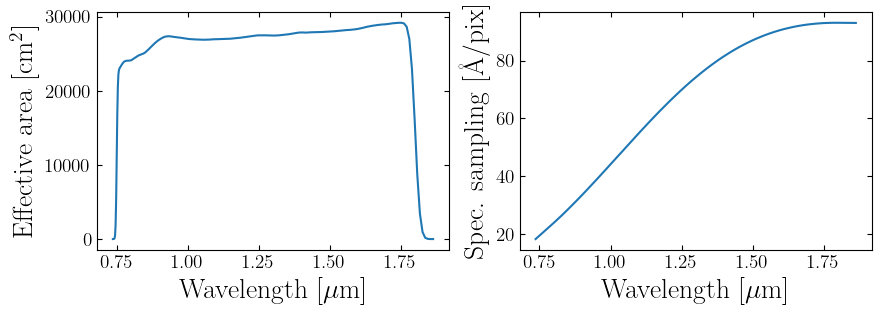

In [14]:
## Plot the effective area and dispersion to get a sense of what they look like
nCols = 2
nRows = 1

xSize = 10
ySize = nRows * xSize / nCols / GOLDEN_RATIO

fig, axes = plt.subplots(figsize=(xSize, ySize), ncols=nCols, nrows=nRows, sharex=True, sharey=False)

axes[0].plot(wavePix.to(u.micron), effArea)

axes[0].set_ylabel(r'Effective area [cm$^2$]');

axes[1].plot(wavePix.to(u.micron), dispersion)

for i in range(nCols):
    axes[i].set_xlabel(r'Wavelength [$\mu$m]');
axes[1].set_ylabel(r'Spec. sampling [\AA/pix]');

A disclaimer to the readers is that these values are pre-launch and pre-TVAC values. The real values will vary not only for each WFI detector but also potentially for different position on each detector. See <a href="https://www.spiedigitallibrary.org/journals/Journal-of-Astronomical-Telescopes-Instruments-and-Systems/volume-11/issue-02/025001/Compact-prism-assembly-for-slit-less-spectroscopy-capability-in-Roman/10.1117/1.JATIS.11.2.025001.full">Eegholm et al. (2025)</a> for some examples.

In [15]:
## To compare between the extracted calibrated spectrum and the true supernova spectrum, we're going to re-use SNCosmo 
## to generate the true 1d spectra in wavePix grid
true1dSpec_resampled_flam = model.flux(t0, wavePix.to_value(u.angstrom)) * syn.units.FLAM
true1dSpec_resampled = syn.units.convert_flux(wavePix, true1dSpec_resampled_flam, syn.units.PHOTLAM)

<Figure size 800x988.854 with 0 Axes>

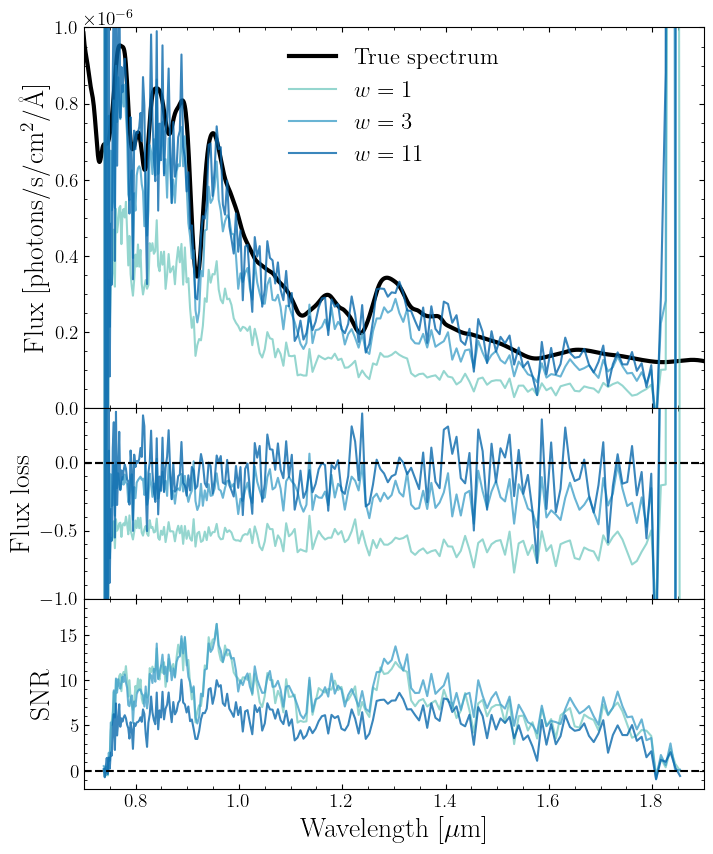

In [16]:
nRows = 3
nCols = 1

xSize = 8
ySize = 2 * xSize / GOLDEN_RATIO

xMin, xMax = 0.7000, 1.9000
dX, dMX = 0.2000, 0.0500

yMin, yMax = 0.0, 1.e-6

opacity = 0.8

plotting.def_plot_values_extra_large()

fig = plt.figure(figsize=(xSize, ySize))

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=False, figsize=(xSize, ySize), height_ratios=[1.0, 0.5, 0.5])

plt.subplots_adjust(hspace=0.0)

## This is the true flux of the supernova that we have showed earlier, plotted here for comparison
axes[0].plot(LAMBDA_GRID.to(u.micron), sn_flux_photlam, 'k-', label='True spectrum', linewidth=3)

axes[1].axhline(color='k', linestyle='--')

for k, (dK, color) in enumerate(zip(dKs, colors)):
    label = '$w = '+'{0:d}'.format(2 * dK + 1)+'$'
    
    spec1dNoisy  = spec1d_uncalib[k] * u.adu / u.pix
    spec1dStdDev = spec1d_uncalib_stdDev[k] * u.adu / u.pix

    ## Here the spectrum is divided by the spectral sampling, effective area, and the exposure time
    spec1d_cal_noisy = (spec1dNoisy / exposureTimeSp / effArea / dispersion) / (1.0 * u.adu / u.ph)
    spec1d_cal_std   = (spec1dStdDev /  exposureTimeSp / effArea / dispersion) / (1.0 * u.adu / u.ph)

    axes[0].plot(wavePix.to(u.micron), spec1d_cal_noisy, '-', color=color, label=label, alpha=opacity)

    fluxLoss = (spec1d_cal_noisy - true1dSpec_resampled) / true1dSpec_resampled

    axes[1].plot(wavePix.to(u.micron), fluxLoss, '-', color=color, label=label, alpha=opacity)

    snr_cal = spec1d_cal_noisy / spec1d_cal_std

    axes[2].plot(wavePix.to(u.micron), snr_cal, '-', color=color, label=label, alpha=opacity)
    
axes[0].set_xlim(xMin, xMax)
axes[0].set_ylim(0.0, yMax)
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(dX))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(dMX))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(2.0e-7))
axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.5e-7))

axes[0].legend(frameon=False)

axes[0].set_ylabel(r'Flux [photons/s/cm$^2$/\AA]')

dY, dMY = 0.5, 0.1

axes[1].axhline(linestyle='--', color='k')

axes[1].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[1].set_ylim(-1.0, +0.4)

axes[1].set_ylabel(r'Flux loss');

axes[2].axhline(linestyle='--', color='k')

axes[2].set_xlabel(r'Wavelength [$\mu$m]')

dY, dMY = 5, 1

axes[2].set_ylim(-2.0, +19.0)
axes[2].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[2].set_ylabel(r'SNR');

## outFilename = "{0:s}/plot_1dSpectralExtraction_simpleSummation_calibrated.pdf".format(OUTDIR)
## fig.savefig(outFilename, bbox_inches='tight')

We can see here that due to the PSF convolution, the flux loss is more severe at redder wavelengths. We increase the aperture width but this will increase noise and reduce the signal-to-noise ratio.

Let's see if we can mitigate this by using optimum spectral extraction.

## Optimum spectral extraction (Horne 1986)

How can we do better? In simple summation to extract a 1d spectrum from a 2d spectal image, we give equal weights to all the cross-dispersion pixels that we sum, even though most of the light is in a central row along the dispersion axis. If we can just weight the pixels accordingly, where the brightest pixel along the cross-dispersion axis is weighted more than those from the central row, we might be able to do better...
<br>
Let's see how we can assign the proper weights to all these pixels...

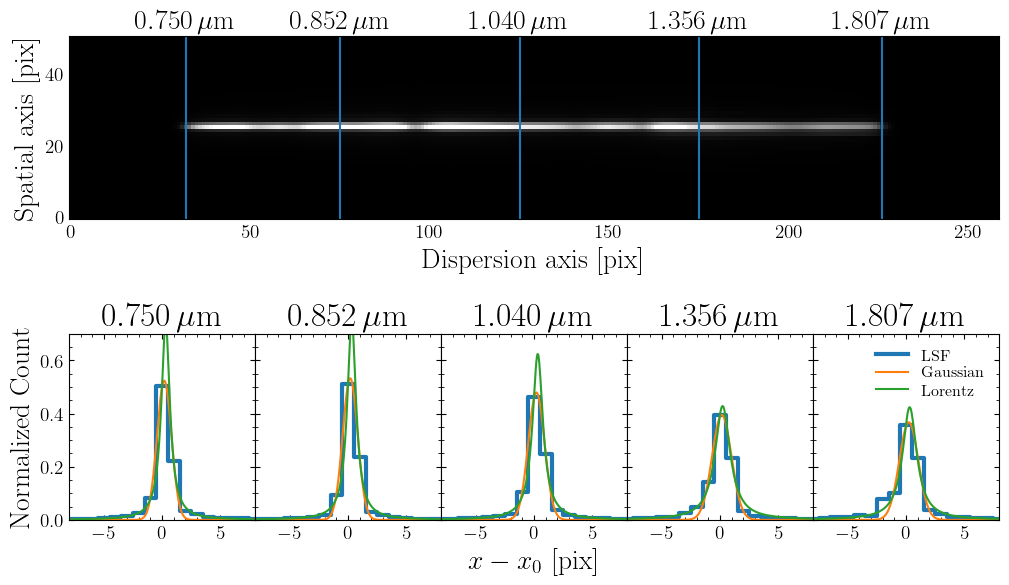

In [17]:
xSize = 12
ySize = 0.9 * xSize / GOLDEN_RATIO

fig = plt.figure(figsize=(xSize, ySize))

gs = GridSpec(2, 5, figure=fig, wspace=0.0, hspace=0.40, height_ratios=[1.0, 1.0])

ax0 = fig.add_subplot(gs[0,:])

## Get the data again and transpose so that the dispersion axis is along the horizontal axis
noiseFreeSpec = hduList['True'].data.T

## Get the shape of the (transposed) postaged stamp
nK, nM = noiseFreeSpec.shape

## Get the central row and the starting column of the wavelength grid 
y_c, x_c = (nK // 2), int(hduList['WAVEPIX', 1].header['W_REFPIX'])

## Just to make things easy, create a grid of pixel coordinates
xx, yy = np.meshgrid(np.arange(nM), np.arange(nK))

## Select an arbitrary wavelength slice where we want to display the LSF
waveSlices = np.array([7, 50, 100, 150, wavePix.size-7], dtype=int)

vmin = 0
vmax = np.percentile(noiseFreeSpec, 99.5)

## Display the noise-free image
ax0.imshow(noiseFreeSpec, aspect='equal', cmap='gray', origin='lower', vmin=vmin, vmax=vmax, interpolation='nearest')

ax0.set_xlabel(r'Dispersion axis [pix]')
ax0.set_ylabel(r'Spatial axis [pix]')

dX, dMX = 50, 10
dY, dMY = 20, 5

ax0.xaxis.set_major_locator(ticker.MultipleLocator(dX))
ax0.xaxis.set_minor_locator(ticker.MultipleLocator(dMX))

ax0.yaxis.set_major_locator(ticker.MultipleLocator(dY))
ax0.yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

xRange = 7.99
yMax   = 0.70

dX, dMX = 5.0, 1.0
dY, dMY = 0.2, 0.05

## Declare the fitter to model the LSF and two models: Gaussian and Lorentz function
fitter = modeling.fitting.LevMarLSQFitter()
models = [modeling.models.Gaussian1D(), 
          modeling.models.Lorentz1D()]
modelNames = ['Gaussian', 'Lorentz']

## Number of points for modelling
nPoints = 1 + 2 ** 12 ## We're going to normalize the model LSF to unity, so we use this scheme for Romberg integration

for k, waveSlice in enumerate(waveSlices):
    wavelength = wavePix[waveSlice]

    label = r'$'+'{0:0.3f}'.format(wavelength.to_value(u.micron))+r'\,\mu$m'
    
    xSlice = waveSlice + x_c
    
    ax0.axvline(xSlice)
    ax0.text(xSlice, nK, label, ha='center', va='bottom')

    lsf     = (noiseFreeSpec[:,xSlice])
    yCoords = yy[:,xSlice] - y_c

    lsfNorm = lsf.sum()

    yModel = np.linspace(-102.4, +102.4, nPoints, endpoint=True)

    dy = yModel[1] - yModel[0]
    
    ax1 = fig.add_subplot(gs[1,k])

    ax1.set_title(label)

    ax1.step(yCoords, lsf / lsfNorm, where='mid', linewidth=3, label='LSF')

    for model, model_label in zip(models, modelNames):
        fittedModel = fitter(model, yCoords, lsf)

        lsfModel = fittedModel(yModel)

        norm = integrate.romb(lsfModel, dx=dy)

        ## print(model_label, fittedModel.amplitude, norm, lsf.sum(), dy)

        ax1.plot(yModel, lsfModel / lsfNorm, '-', label=model_label, rasterized=True)

    ax1.set_xlim(-xRange, +xRange)

    ax1.set_ylim(0, yMax)

    if (k > 0):
        ax1.set_yticklabels('')
    else:
        ax1.set_ylabel(r'Normalized Count')

    if (k == int(waveSlices.size // 2)):
        ax1.set_xlabel(r'$x - x_0$ [pix]')        

    ax1.xaxis.set_major_locator(ticker.MultipleLocator(dX))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(dMX))

    ax1.yaxis.set_major_locator(ticker.MultipleLocator(dY))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

    xMin, xMax = ax1.get_xlim()
    yMin, yMax = ax1.get_ylim()

    ax1.set_aspect((xMax - xMin) / (yMax - yMin))

ax1.legend(frameon=False, fontsize='xx-small', labelspacing=0.2);

As we can see, we can assign weights to pixels along the cross-dispersion axis according to how far they are from the central row. We can also see that a Lorentz function is a better function than a Gaussian function, as it can model the wings of the distribution better.
<br>
However, we can also see that the width of the Lorentz function vary along the dispersion axis, which correspond to the wavelength axis. It is wider in the redder part of the spectrum than in the bluer part. We also have take this into account.
<br>
Pre-launch instrument testing and more in-flight calibration works can reveal how the width of the Lorentz function changes with wavelength. For now we use simulated data to find this out.
<br>
As a reminder here's what a Gaussian (also called the normal distribution) function that we all know and love looks like:
\begin{equation}
f(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x - \mu)^2}{2\sigma^2}\right],
\end{equation}
and here's what a Lorentz function (also called the Cauchy function) looks like:
\begin{equation}
f(x; x_0, \gamma) = \frac{1}{\pi}\left[\frac{\gamma}{(x - x_0)^2 + \gamma^2}\right].
\end{equation}
Like a normal distribution, it is defined by two parameters: the zero point $x_0$ and width $\gamma$.

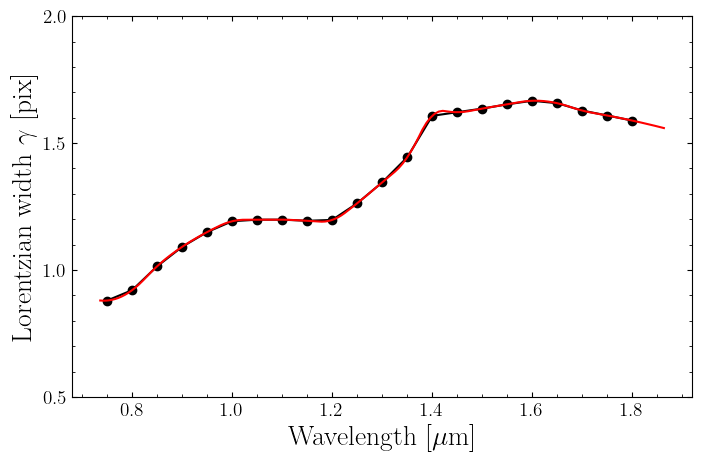

In [18]:
lorentzParameterFilename = "/Users/tastraatmadja/Research/roman/optimum_spectral_extraction/LSF_lorentzParameters_nPulse0022.csv"

df = pd.read_csv(lorentzParameterFilename)## .drop(index=[19,20,21]) ## .drop(index=[1,4,5,6,13])

wave  = (df['wavelength'].values * u.nanometer).to(u.angstrom)
gamma = df['gamma'].values

f = interpolate.interp1d(wave, gamma, kind='quadratic', fill_value='extrapolate')

xSize = 8
ySize = xSize / GOLDEN_RATIO

plotting.def_plot_values_extra_large()
fig = plt.figure(figsize=(xSize, ySize))
ax  = fig.add_subplot(111)

ax.plot(wave.to(u.micron), gamma, 'ko-')

yMin, yMax = ax.get_ylim()

ax.plot(wavePix.to(u.micron),f(wavePix.value), 'r-')

## ax.set_ylim(yMin, yMax)

ax.set_ylim(0.5, 2.0)

ax.set_xlabel(r'Wavelength [$\mu$m]')

ax.set_ylabel(r'Lorentzian width $\gamma$ [pix]');

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

In [19]:
## Get the relevant data again
noisySpec = hduList['SCI', 1].data.T
varImage  = hduList['ERR', 1].data.T ** 2
tExp      = float(hduList['SCI', 1].header['exptime']) * u.s

nK, nM = noisySpec.shape
    
y_c, x_c = (nK // 2), int(hduList['WAVEPIX', 1].header['W_REFPIX'])

xxMin, xxMax = x_c, x_c + hduList['WAVEPIX', 1].data['wavelength'].size

Another thing what we have to worry about, other than the weighting along the cross-dispersion axis and the width of the Lorentz function along the dispersion axis, is the zero point $x_0$ of the Lorentz function! We can find this by applying a centroiding algorithm using the Lorentz function as the model and setting $x_0$ as one of the parameters to solve.
<br>
This is a whole discussion in itself so we're not going to do that here. We're going to use the value written in the header, which is `SHIFT_X`:

In [20]:
## We call the value SHIFT_X in the header but we assign it as shiftY because now the image is transposed.
shiftY = hduList['SCI', 1].header['shift_x'] * u.arcsecond 

We are now ready to extract a 1d spectrum from the 2d spectral image using optimum spectral extraction.

In [21]:
## First we create an array to store the values of the Lorentzian HWHM as a function of the wavelength, and
## the weight array itself.
gammaInterp = np.zeros(wavePix.size)
weights     = np.zeros((wavePix.size, nPP))

## We also declare an empty array to store the extracted 1d spectrum and the uncertainties
spec1d_opt_noisy  = np.empty(wavePix.size)
spec1d_opt_stdDev = np.empty(wavePix.size)

In [22]:
## Because we believe we now can properly weight the pixels, we set the extraction length
## to be very long, i.e. all pixels along the cross-dispersion axis in the postage stamp
dK = np.inf

## Again we re-calculate
yyMin = max(y_c-dK, 0)    ## Inclusive
yyMax = min(y_c+dK+1, nK) ## EXCLUSIVE. So add an additional 1 pixel

print(dK, y_c, yyMin, yyMax)

## Also, we'll set up an array of pixel coordinates centered on y_c so we can quickly
## calculate the weights from the Lorentzian model
pixCoords = np.arange(nK, dtype=float) - y_c

print(pixCoords)

inf 25 0 51
[-25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12.
 -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.
   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.]


(51,)
100 1.0400522364005311 micron 1.198073604343913
0.033 arcsec 0.3 pix


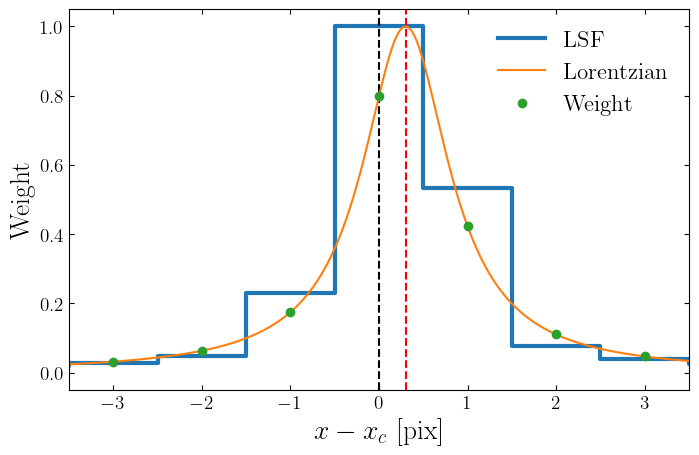

In [23]:
waveSlice = waveSlices[2]

wavelength = wavePix[waveSlice]

x_c = int(hduList['WAVEPIX', 1].header['W_REFPIX'])

xSlice = waveSlice + x_c

lsf = (noiseFreeSpec[:,xSlice])

print(lsf.shape)

gamma_test = f(wavelength.value)
shiftY_pix = shiftY / constants.ROMAN_PIXSCALE
## shiftY_test     = 0.033 * u.arcsecond
## shiftY_test_pix = shiftY_test / constants.ROMAN_PIXSCALE

print(waveSlice, wavelength.to(u.micron), gamma_test)

print(shiftY, shiftY_pix)

model = modeling.models.Lorentz1D(x_0=shiftY_pix.value, amplitude=1.0, fwhm=gamma_test)

xSize = 8
ySize = xSize / GOLDEN_RATIO

fig, ax = plt.subplots(figsize=(xSize, ySize))

smooth_pixCoords = np.arange(0, nK, 0.01, dtype=float) - y_c

ax.step(pixCoords, lsf / np.nanmax(lsf), where='mid', linewidth=3, label='LSF')

ax.axvline(0, color='k', linestyle='--')
ax.axvline(shiftY_pix.value, color='r', linestyle='--')

ax.plot(smooth_pixCoords, model(smooth_pixCoords), '-', label='Lorentzian')
ax.plot(pixCoords, model(pixCoords), 'o', label='Weight')

ax.set_xlim(-3.5, +3.5)

ax.set_xlabel(r'$x - x_c$ [pix]')
ax.set_ylabel(r'Weight')

ax.legend(frameon=False)

We're now going to optimally extract the 1d spectrum. Here's what we're going to do:
\begin{equation}
\begin{split}
s_{{\rm opt}, l}        &= \frac{\sum_i\frac{w_i f_i}{\sigma^2_i}}{\sum_i \frac{w^2_i}{\sigma^2_i}}, \\
\sigma^2_{{\rm opt}, l} &= \frac{\sum_i w_i}{\sum_i \frac{w^2_i}{\sigma^2_i}}.
\end{split}
\end{equation}

In [24]:
## Here's the main event. We're going to do the weighting wavelength-by-wavelength. For a given wavelength we'll
## set up a Lorentzian 1D model using astropy with the proper width, zero point
for l in range(wavePix.size):
    gammaInterp[l] = f(wavePix[l].value)

    model = modeling.models.Lorentz1D(x_0=(shiftY / constants.ROMAN_PIXSCALE).value, amplitude=1.0, fwhm=gammaInterp[l])

    weights[l] = model(pixCoords)

    weights[l] = weights[l] / weights[l, yyMin:yyMax].sum()

    spec1d_opt_noisy[l]  = np.sum(weights[l, yyMin:yyMax] * noisySpec[yyMin:yyMax,l+xxMin] / varImage[yyMin:yyMax,l+xxMin]) / np.sum(weights[l, yyMin:yyMax]**2 / varImage[yyMin:yyMax,l+xxMin])
    spec1d_opt_stdDev[l] = np.sqrt(np.sum(weights[l, yyMin:yyMax]) / np.sum(weights[l, yyMin:yyMax]**2 / varImage[yyMin:yyMax,l+xxMin]))

    spec1d_opt_noisy[l]  = (spec1d_opt_noisy[l] / tExp / effArea[l] / dispersion[l]).value
    spec1d_opt_stdDev[l] = (spec1d_opt_stdDev[l] / tExp / effArea[l] / dispersion[l]).value

spec1d_opt_noisy *= syn.units.PHOTLAM
spec1d_opt_stdDev *= syn.units.PHOTLAM

fluxLoss_opt = (spec1d_opt_noisy - true1dSpec_resampled) / true1dSpec_resampled

snr_opt = spec1d_opt_noisy / spec1d_opt_stdDev

<Figure size 800x988.854 with 0 Axes>

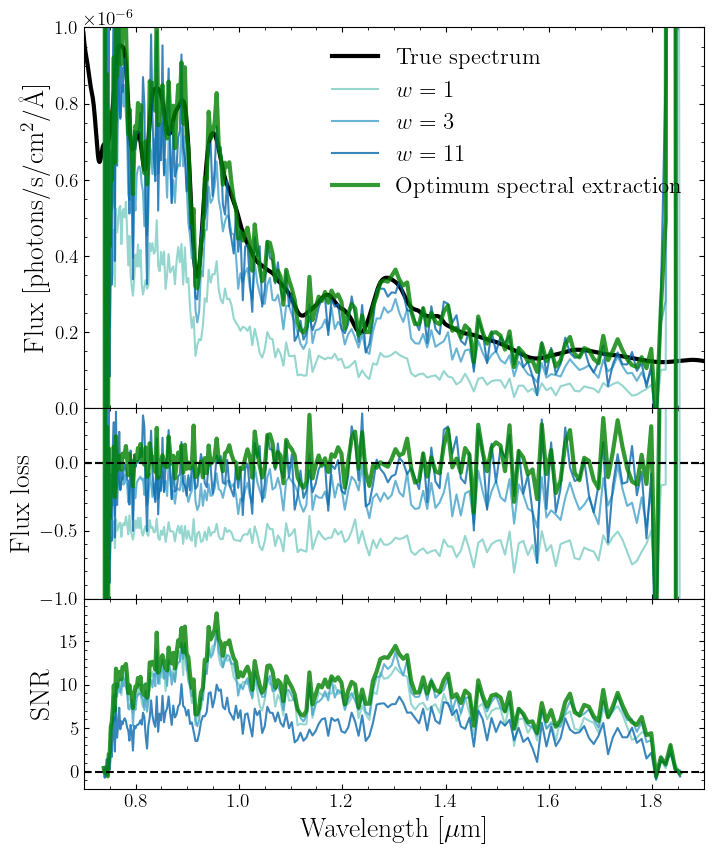

In [25]:
nRows = 3
nCols = 1

xSize = 8
ySize = 2 * xSize / GOLDEN_RATIO

xMin, xMax = 0.7000, 1.9000
dX, dMX = 0.2000, 0.0500

yMin, yMax = 0.0, 1.e-6

opacity = 0.8

plotting.def_plot_values_extra_large()

fig = plt.figure(figsize=(xSize, ySize))

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=False, figsize=(xSize, ySize), height_ratios=[1.0, 0.5, 0.5])

plt.subplots_adjust(hspace=0.0)

axes[0].plot(LAMBDA_GRID.to(u.micron), sn_flux_photlam, 'k-', label='True spectrum', linewidth=3)

axes[1].axhline(color='k', linestyle='--')

for k, (dK, color) in enumerate(zip(dKs, colors)):
    label = '$w = '+'{0:d}'.format(2 * dK + 1)+'$'
    
    spec1dNoisy  = spec1d_uncalib[k] * u.adu / u.pix
    spec1dStdDev = spec1d_uncalib_stdDev[k] * u.adu / u.pix

    ## Here the spectrum is divided by the spectral sampling, effective area, and the exposure time
    spec1d_cal_noisy = (spec1dNoisy / exposureTimeSp / effArea / dispersion) / (1.0 * u.adu / u.ph)
    spec1d_cal_std   = (spec1dStdDev /  exposureTimeSp / effArea / dispersion) / (1.0 * u.adu / u.ph)

    axes[0].plot(wavePix.to(u.micron), spec1d_cal_noisy, '-', color=color, label=label, alpha=opacity)

    fluxLoss = (spec1d_cal_noisy - true1dSpec_resampled) / true1dSpec_resampled

    axes[1].plot(wavePix.to(u.micron), fluxLoss, '-', color=color, label=label, alpha=opacity)

    snr_cal = spec1d_cal_noisy / spec1d_cal_std

    axes[2].plot(wavePix.to(u.micron), snr_cal, '-', color=color, label=label, alpha=opacity)

opt_color ='green'

axes[0].plot(wavePix.to(u.micron), spec1d_opt_noisy, '-', color=opt_color, label='Optimum spectral extraction', linewidth=3, alpha=opacity)
axes[1].plot(wavePix.to(u.micron), fluxLoss_opt, '-', color=opt_color, linewidth=3, alpha=opacity)
axes[2].plot(wavePix.to(u.micron), snr_opt, '-', color=opt_color, linewidth=3, alpha=opacity)

axes[0].set_xlim(xMin, xMax)
axes[0].set_ylim(0.0, yMax)
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(dX))
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(dMX))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(2.0e-7))
axes[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.5e-7))

axes[0].legend(frameon=False)

dY, dMY = 0.5, 0.1

axes[1].axhline(linestyle='--', color='k')

axes[1].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[1].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[1].set_ylim(-1.0, +0.4)

axes[0].set_ylabel(r'Flux [photons/s/cm$^2$/\AA]')

axes[1].set_ylabel(r'Flux loss')

axes[2].axhline(linestyle='--', color='k')

axes[2].set_xlabel(r'Wavelength [$\mu$m]')

dY, dMY = 5, 1

axes[2].set_ylim(-2.0, +19.9)
axes[2].yaxis.set_major_locator(ticker.MultipleLocator(dY))
axes[2].yaxis.set_minor_locator(ticker.MultipleLocator(dMY))

axes[2].set_ylabel(r'SNR');